Looking at answering the question: **Given the route, time, and season, what is the expected ridership?**

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd


In [ ]:
df_all = pd.read_csv("../../../data/riderhsip/cleaned_mbta_ridership_2016_2024.csv")

/tmp/ipython-input-1241033601.py:1: DtypeWarning: Columns (1,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv("/content/drive/MyDrive/CS506/data/riderhsip/cleaned_mbta_ridership_2016_2024.csv")


In [4]:
df_all['route_id'] = df_all['route_id'].astype(str)
df_all['day_type_name'] = df_all['day_type_name'].astype(str)
df_all['season'] = df_all['season'].astype(str)
df_all['year'] = df_all['year'].astype(str)


In [5]:
df_sample = df_all.sample(200_000, random_state=42)

In [6]:
#route × hour × day_type × season × year demand instead--reduces num of rows by a lot, dont rly need stop level info at this time
df_agg = df_all.groupby(['route_id','hour','day_type_name','season','year'])['boardings'].sum().reset_index()

for col in ['route_id','day_type_name','season','year']:
    df_agg[col] = df_agg[col].astype(str)


train = df_agg[df_agg['year'].astype(int) <= 2021]
test  = df_agg[df_agg['year'].astype(int) > 2021]

X_train = train[['hour','day_type_name','season','year','route_id']]
y_train = train['boardings']
X_test = test[['hour','day_type_name','season','year','route_id']]
y_test = test['boardings']

#using one hot
categorical = ['day_type_name','season','route_id']
numeric = ['hour','year']
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('num', 'passthrough', numeric)
])

#starting with smaller forest size for now
model = Pipeline([
    ('prep', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=20, max_depth=20, random_state=42))
])

model.fit(X_train, y_train)
preds = model.predict(X_test)

print('MAE:', mean_absolute_error(y_test, preds))
print('R²:', r2_score(y_test, preds))


MAE: 40.011344986012304
R²: 0.7489096543835372


In [7]:
#elect one test sample
sample_row = X_test.iloc[[0]]  # double brackets to keep df shape
true_value = y_test.iloc[0]
pred_value = model.predict(sample_row)[0]

print("Example input:\n", sample_row)
print("\nTrue boardings:", true_value)
print("Predicted boardings:", round(pred_value, 1))
print("Error:", round(pred_value - true_value, 1))


Example input:
    hour day_type_name season  year route_id
6     0      saturday   Fall  2022        1

True boardings: 103.2
Predicted boardings: 78.1
Error: -25.1


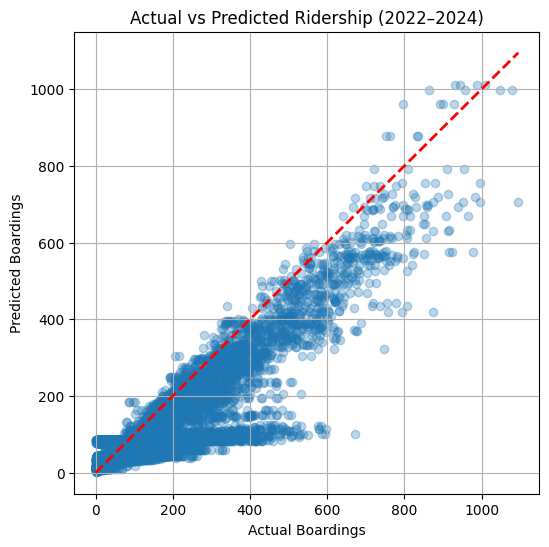

In [8]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6,6))
plt.scatter(y_test, preds, alpha=0.3)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Boardings")
plt.ylabel("Predicted Boardings")
plt.title("Actual vs Predicted Ridership (2022–2024)")
plt.grid(True)
plt.show()


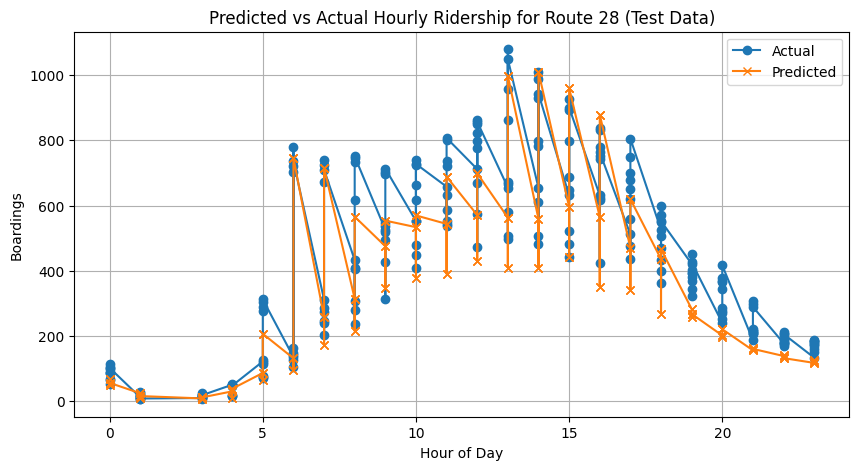

In [10]:
route = '28'
route_test = test[test['route_id']==route]

route_preds = model.predict(route_test[['hour','day_type_name','season','year','route_id']])

plt.figure(figsize=(10,5))
plt.plot(route_test['hour'], route_test['boardings'], label="Actual", marker='o')
plt.plot(route_test['hour'], route_preds, label="Predicted", marker='x')
plt.title(f"Predicted vs Actual Hourly Ridership for Route {route} (Test Data)")
plt.xlabel("Hour of Day")
plt.ylabel("Boardings")
plt.legend()
plt.grid(True)
plt.show()